In [1]:
import pickle
import time
from pathlib import Path

import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.dummy import DummyClassifier

SEED = 123
BASELINE_RATIO = 0.2

# the parameters are set to 1 for demonstration purposes 
SVC_TRIALS = 1  # adjust as needed (70 in the write-up)
LGBM_TRIALS = 1  # adjust as needed (40 in the write-up)

# Let's get the dataset

We are retrieving the dataset from the file created by the `Data Processing.ipynb` notebook.

In [2]:
df = pd.read_csv('dataset_rw.csv')
for dt_col in ['opp_estimated_close_date', 'CreatedDate', 'first_created_date']:
    df[dt_col] = pd.to_datetime(df[dt_col])
print(f"{df.shape=}")
df.head()

df.shape=(160311, 137)


,Unnamed: 0,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,...,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0
1,1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
2,2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q1,0
3,3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q3,0
4,4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-10-12,2022Q2,2023Q2,0


In [3]:
df.describe()

,Unnamed: 0,opp_estimated_close_date,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,...,n_recipients__fc__x,mean_n_recipients__fc__x,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,target
count,160311.000000,160311,160311,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,...,160311.000000,160311.000000,160311.00000,160311.000000,160311.000000,160311.000000,160311.000000,160311.000000,160311,160311.000000
mean,80155.000000,2022-11-11 12:25:56.764039680,2022-07-09 11:02:26.123472896,0.043260,0.029911,4.420707,0.152441,0.100162,0.056303,55.555464,...,16.938307,0.960570,38.68475,1.309816,4.747360,0.824527,8.884325,2.032249,2022-03-06 09:38:55.482904832,0.050146
min,0.000000,2021-10-12 00:00:00,2021-10-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
25%,40077.500000,2022-07-25 00:00:00,2022-02-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
50%,80155.000000,2022-11-03 00:00:00,2022-06-20 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-12-09 00:00:00,0.000000
75%,120232.500000,2023-03-10 00:00:00,2022-11-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.142857,23.00000,1.571429,0.000000,0.000000,0.000000,0.000000,2022-07-06 00:00:00,0.000000
max,160310.000000,2023-09-08 00:00:00,2023-09-08 00:00:00,21.000000,21.000000,25935.000000,696.000000,37.000000,37.000000,108647.000000,...,2575.000000,24.000000,2786.00000,124.499999,632.000000,281.999997,1446.000000,275.999997,2023-08-23 00:00:00,1.000000
std,46277.943839,NaN,NaN,0.369076,0.290704,126.746176,3.637546,0.566949,0.396776,680.837500,...,93.709678,2.049748,131.82972,2.684039,35.887491,8.016977,53.876738,9.143741,NaN,0.218247


In [4]:
# reduce N because the stats are not impacted
df = df[df.CreatedDate.dt.day.isin([1, 7, 13, 19, 25])]
df.describe()

,Unnamed: 0,opp_estimated_close_date,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,duration_in__tc,...,n_recipients__fc__x,mean_n_recipients__fc__x,n_recipients__tc__x,mean_n_recipients__tc__x,n_recipients__fo__x,mean_n_recipients__fo__x,n_recipients__me__x,mean_n_recipients__me__x,first_created_date,target
count,26415.000000,26415,26415,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,...,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415.000000,26415,26415.000000
mean,79860.546091,2022-11-10 22:50:59.080068352,2022-07-08 10:07:20.749574400,0.042476,0.029756,3.840356,0.139239,0.102328,0.056975,57.159947,...,16.779708,0.958443,38.455537,1.305769,4.729510,0.822812,8.818361,2.029526,2022-03-05 15:30:17.376490496,0.050085
min,289.000000,2021-10-13 00:00:00,2021-10-13 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
25%,40603.500000,2022-07-20 00:00:00,2022-02-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-10-12 00:00:00,0.000000
50%,79810.000000,2022-11-01 00:00:00,2022-06-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021-12-08 00:00:00,0.000000
75%,119588.500000,2023-03-08 00:00:00,2022-11-07 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.142857,23.000000,1.571429,0.000000,0.000000,0.000000,0.000000,2022-07-06 00:00:00,0.000000
max,160308.000000,2023-09-08 00:00:00,2023-09-07 00:00:00,12.000000,11.000000,5161.000000,172.000000,37.000000,37.000000,60450.000000,...,2307.000000,24.000000,2668.000000,83.333333,632.000000,281.999997,1434.000000,275.999997,2023-08-23 00:00:00,1.000000
std,46363.169096,NaN,NaN,0.359426,0.278084,78.639930,2.136550,0.584251,0.416007,687.800043,...,92.740013,2.050190,131.160686,2.660168,35.854423,8.033803,53.366603,9.136328,NaN,0.218125


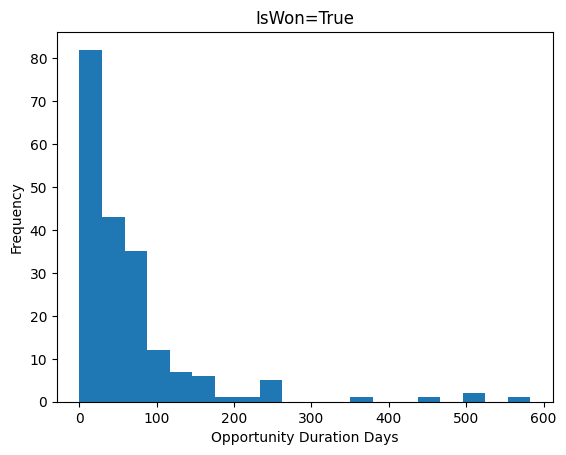

count    197.000000
mean      65.182741
std       85.618858
min        0.000000
25%       17.000000
50%       38.000000
75%       76.000000
max      583.000000
Name: duration, dtype: float64


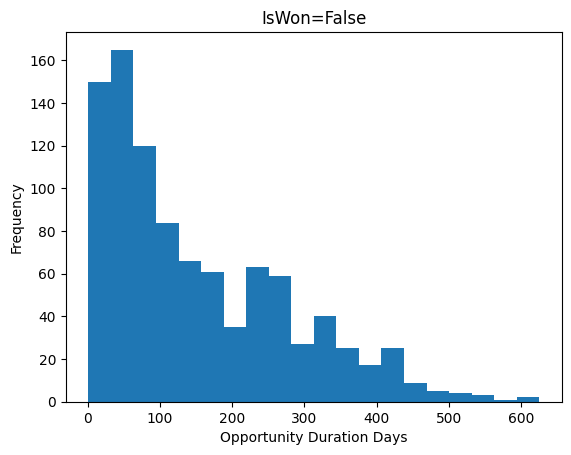

count    961.000000
mean     152.177940
std      126.689954
min        1.000000
25%       48.000000
50%      110.000000
75%      240.000000
max      625.000000
Name: duration, dtype: float64


In [5]:
df = df.sort_values('CreatedDate', ascending=True)

# plot opportunity duration distributions for each opportunity
for won in [True, False]:
    df_won = df[df.IsWon == won].copy()
    # keep first mention of the opportunity in the dataset
    df_won_unique = df_won.drop_duplicates('OpportunityId').copy() 
    df_won_unique.loc[:, 'duration'] = (df_won_unique['opp_estimated_close_date'] -
                                        df_won_unique['first_created_date']).dt.days
    df_won_unique['duration'].plot.hist(bins=20, title=f'IsWon={won}')
    plt.xlabel('Opportunity Duration Days')
    plt.show()
    print(df_won_unique['duration'].describe())

Based on the above, lost opportunities tend to last much longer (mean=151 days vs 57 days for won opportunities). Thus, the current duration of the opportunity might also be a strong predictor of whether it will close successfully or not.


<Axes: xlabel='Current Duration', ylabel='Frequency'>

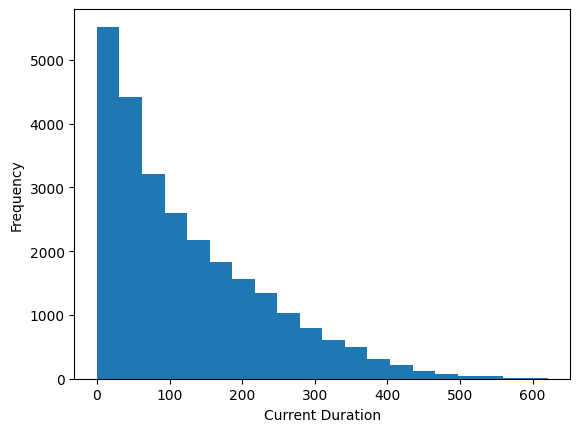

In [6]:
df['current_duration'] = (df['CreatedDate'] - df['first_created_date']).dt.days
df['current_duration'].plot.hist(bins=20, xlabel='Current Duration')

Let's define some training columns for the baseline model. We will start with the 7-day rolling window features representing the number of communications for inbound, outbound, indirect emails as well as meetings as well as the expanding feature of outbound emails.

In [7]:
train_columns = ['current_duration'] + [x for x in list(df) if ((x.startswith('n__') or x.startswith('mean_')) and x.count('_fo') == 0)]
train_columns

['current_duration',
 'n__fc',
 'n__tc',
 'n__me',
 'n__fc__rw7',
 'n__tc__rw7',
 'n__me__rw7',
 'mean_duration_in__fc__rw7',
 'mean_duration_in__tc__rw7',
 'mean_duration_in__me__rw7',
 'mean_owner_included__fc__rw7',
 'mean_owner_included__tc__rw7',
 'mean_owner_included__me__rw7',
 'mean_n_recipients__fc__rw7',
 'mean_n_recipients__tc__rw7',
 'mean_n_recipients__me__rw7',
 'n__fc__rw30',
 'n__tc__rw30',
 'n__me__rw30',
 'mean_duration_in__fc__rw30',
 'mean_duration_in__tc__rw30',
 'mean_duration_in__me__rw30',
 'mean_owner_included__fc__rw30',
 'mean_owner_included__tc__rw30',
 'mean_owner_included__me__rw30',
 'mean_n_recipients__fc__rw30',
 'mean_n_recipients__tc__rw30',
 'mean_n_recipients__me__rw30',
 'n__fc__rw90',
 'n__tc__rw90',
 'n__me__rw90',
 'mean_duration_in__fc__rw90',
 'mean_duration_in__tc__rw90',
 'mean_duration_in__me__rw90',
 'mean_owner_included__fc__rw90',
 'mean_owner_included__tc__rw90',
 'mean_owner_included__me__rw90',
 'mean_n_recipients__fc__rw90',
 'mean_n

The code below shows the distribution of the positive classes across different levels of data aggregation. 18.9% of opportuntiies are won at some point. Less so, only 8% of opportunity-quarters are positive. This means that opportunities, on average, even if won eventually, are won after several quarters of being open (being a negative class). 

Finally, only 5% of the opportunity-days represent positive classes. This means that there will be a high class imbalance that we will need to account for.

In [8]:
# this column shows the % of the opportunities closed successfully
p_opp_won = df.groupby(['OpportunityId'], as_index=False).agg(
    {'target': 'max'}).target.astype(int).mean()
p_opp_fq_won = df.groupby(
    ['OpportunityId', 'CreatedDate__fq'], as_index=False
).agg({'target': 'first'}).target.astype(int).mean()
# and the number of rows that have target == 1
p_samples_won = df.target.mean()

print(f"% of Opportunities Won: {p_opp_won*100:.2f}%")
print(f"% of Opportunity-FQs Won: {p_opp_fq_won*100:.2f}%")
print(f"% of Opportunity-Days Won: {p_samples_won*100:.2f}%")

% of Opportunities Won: 17.01%
% of Opportunity-FQs Won: 7.29%
% of Opportunity-Days Won: 5.01%


The below cell groups all opportunity-days by fiscal quarter and opportunity identifier (target for each group is the same). This is used to split the data into training and test sets - we should avoid putting data points from the same opportunity-quarter into two datasets as it might trick the model.

Additionally, after obtaining training the test sets, we further cut the training set to speed up the baseline model training process. The test set is further split into test and validation sets.

The final distribution of data is as follows:
- training set: 60% of all opportunity-quarters
- test set: 20% of all opportunity-quarters
- validation set: 20% of all opportunity-quarters

All opportunity-quarters are split in a stratified way with the outcome variable in mind to ensure that the class imbalance problem doesn't propagate further.

In [9]:
# this identifies unique sets of Opportunities and FQs, because the target 
# is the same for each pair (Opp, FQ)
unique_params = df[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, 
                                             test_size=0.4, 
                                             stratify=unique_params['target'], 
                                             random_state=SEED)

# taking 0.4*0.5 = 0.2 for test and 0.4*0.5=0.2 for validation
test_params, val_params = train_test_split(test_params, 
                                           test_size=0.5, 
                                           stratify=test_params['target'], 
                                           random_state=SEED)

The following cell assigns opportunity-days to train, test, or validation sets based on their identifiers and quarters.

In [10]:
train = []
test = []
val = []

df_shuffled = df.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
val_params = set(list(val_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))


for name, group in grouped:
    if name in train_params:
        train.append(group)
    elif name in test_params:
        test.append(group)
    elif name in val_params:
        val.append(group)

train = pd.concat(train)
test = pd.concat(test)
val = pd.concat(val)


In [11]:
#print(train[train_columns].shape, test[train_columns].shape, val[train_columns].shape)
print(f"Opportunity-days won in df: {df.target.mean():.4f}")
print(f"Opportunity-days won in train: {train.target.mean():.4f}")
print(f"Opportunity-days won in test: {test.target.mean():.4f}")
print(f"Opportunity-days won in test: {val.target.mean():.4f}")

Opportunity-days won in df: 0.0501
Opportunity-days won in train: 0.0490
Opportunity-days won in test: 0.0532
Opportunity-days won in test: 0.0501


From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

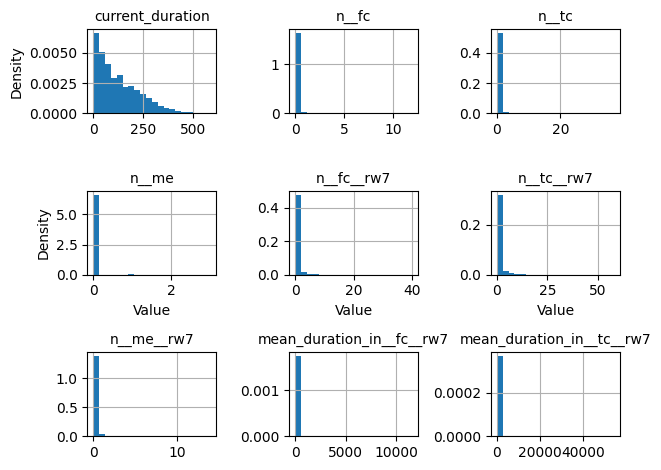

In [12]:
fig, ax = plt.subplots(3, 3)
max_show = min(len(ax.flatten()), len(train_columns))
pl = train[train_columns[:max_show]].hist(density=True, ax=ax.flatten()[:max_show], bins=20)
ax[1][0].set_xlabel('Value')
ax[1][1].set_xlabel('Value')
ax[1][2].set_xlabel('Value')
ax[0][0].set_ylabel('Density')
ax[1][0].set_ylabel('Density')
[x.title.set_size(10) for x in pl.ravel()]
plt.tight_layout()
plt.show()

Since we are using SVCs, it's a good practice to normalize the data. For that, we will take the log of data to reduce its skewness attributable to the high sparsity. Then, we rescale the data to a smaller range of values to optimize for the SVC's speed. We train the scaler on train data but then apply it to the testing and validation sets as well. Final data distributions for train set are provided below

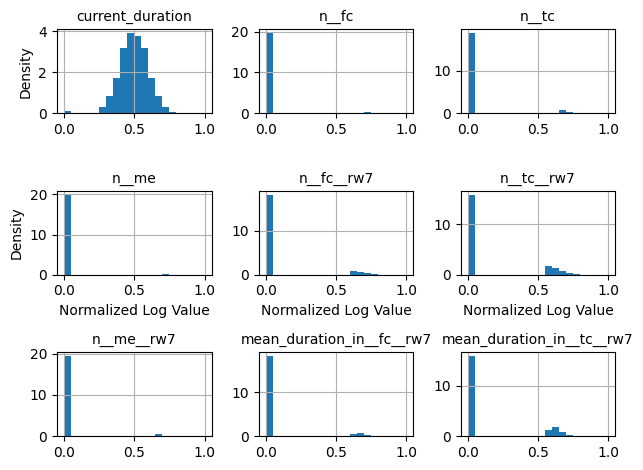

In [13]:
scaler = None
for dataset in [train, test, val]:
    # for feature in train_columns:
    #     dataset[feature] = np.log1p(dataset[feature])

    # this condition will be entered only for the train set
    if not scaler:
        scaler = Pipeline(
            (
                ('quantile', QuantileTransformer(n_quantiles=200, output_distribution='normal', random_state=SEED)),
                ('minmax', MinMaxScaler(feature_range=(0,1)))
            )
        )
        scaler.fit(dataset[train_columns])
        dataset[train_columns] = scaler.transform(dataset[train_columns])

        fig, ax = plt.subplots(3, 3)
        max_show = min(len(ax.flatten()), len(train_columns))
        pl = train[train_columns[:max_show]].hist(density=True, ax=ax.flatten()[:max_show], bins=20)
        
        ax[1][0].set_xlabel('Normalized Log Value')
        ax[1][1].set_xlabel('Normalized Log Value')
        ax[1][2].set_xlabel('Normalized Log Value')
        ax[0][0].set_ylabel('Density')
        ax[1][0].set_ylabel('Density')
        [x.title.set_size(10) for x in pl.ravel()]
        plt.tight_layout()
        plt.show()
    else:
        dataset[train_columns] = scaler.transform(dataset[train_columns])
    



Now, let's add some synthetical samples to the train data to decrease the imbalance. We use SMOTE for this.

In [14]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [15]:
print(f"{train[train_columns].shape}", f"{test[train_columns].shape}")
print(f"Opportunity-days won in train: {train.target.mean():.3f}")
print(f"Opportunity-days won in test: {test.target.mean():.3f}")

(16728, 52) (5377, 52)
Opportunity-days won in train: 0.100
Opportunity-days won in test: 0.053


In [16]:
def get_metrics(y_true, y_pred, y_proba, sample_weights=None) -> dict:
    if isinstance(sample_weights, bool):
        sample_weights = [0.95 if x == 1 else 0.05 for x in y_true ]
    metric = dict()
    metric['f1'] = metrics.f1_score(y_true, y_pred, sample_weight=sample_weights)
    metric['precision'] = metrics.precision_score(y_true, y_pred, sample_weight=sample_weights)
    metric['recall'] = metrics.recall_score(y_true, y_pred, sample_weight=sample_weights)
    metric['matt_score'] = metrics.matthews_corrcoef(y_true, y_pred, sample_weight=sample_weights)
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred, sample_weight=sample_weights)
    metric['pr_auc'] = metrics.auc(recall, precision)
    metric['roc_auc'] = metrics.roc_auc_score(y_true, y_pred, sample_weight=sample_weights)
    metric['log_loss'] = metrics.log_loss(y_true, y_proba, sample_weight=sample_weights)
    metric['bas'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    return metric

def get_report(metrics_dict, prefix=""):
    for key, value in metrics_dict.items():
        tabs = '\t\t' if len(key) <= 6 else '\t'
        print(f"{prefix}\t{key}:{tabs}{value:.4f}")

def get_trial_info(study):
    study_data = []
    for t in study.get_trials():
        study_data.append(t.params | {'metric': t.value, 'trial': t.number})
    return pd.DataFrame(study_data)

def get_best_roc_threshold(true, proba):
    fpr, tpr, thresholds = metrics.roc_curve(true, proba)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print(f'Best Threshold={thresholds[ix]}')
    return thresholds[ix]

In [17]:
# specify loss functions for training and direction to optimize

LOSS_FUNCTION = 'log_loss'
DIRECTION = 'minimize'

In [18]:
def objective_for_stratified(train_data: pd.DataFrame, val_data, trial: optuna.Trial, get_estimator) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    train_data: pd.DataFrame - the train dataset
    val_data: pd.DataFrame - the validation dataset 
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    model, columns = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = (train_data[columns], 
                                        val_data[columns], 
                                        train_data.target, 
                                        val_data.target)
        
    model.fit(x_train, y_train)
        
    # generate predictions for the unseen quarter and save it
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)
    metrics = get_metrics(y_test, y_pred, y_proba, True)

    return metrics[LOSS_FUNCTION]


def optimize(train_data, val_data, objective, get_estimator, n_trials, n_jobs=1):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    Model - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction=DIRECTION, sampler=sampler)
    study.optimize(
        lambda trial: objective(train_data, val_data, trial, get_estimator), 
        n_trials=n_trials, 
        n_jobs=n_jobs,
        timeout=3600,
        )

    # retrieve the best model and fit it
    model, columns = get_estimator(trial=None, params=study.best_params)
    model.fit(train_data[columns], train_data.target)
    return model, columns, study

## Candidate 0: Dummy Classifier

In [19]:
timestamp = int(time.time())

In [20]:
dummy = DummyClassifier(strategy='stratified', random_state=SEED)
dummy.fit(train[train_columns], train.target)
# get predictions 
test['dummy_pred'] = dummy.predict(test[train_columns])
test['dummy_proba'] = dummy.predict_proba(test[train_columns])[:, 1]
train['dummy_pred'] = dummy.predict(train[train_columns])
train['dummy_proba'] = dummy.predict_proba(train[train_columns])[:, 1]
val['dummy_pred'] = dummy.predict(val[train_columns])
val['dummy_proba'] = dummy.predict_proba(val[train_columns])[:, 1]

get_report(get_metrics(train.target, train.dummy_pred, train.dummy_proba, True), prefix="Dummy Train")
print()
get_report(get_metrics(test.target, test.dummy_pred, test.dummy_proba, True), prefix="Dummy Test ")
print()
get_report(get_metrics(val.target, val.dummy_pred, val.dummy_proba, True), prefix="Dummy Val ")

/tmp/ipykernel_105794/2143761273.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['dummy_pred'] = dummy.predict(test[train_columns])
/tmp/ipykernel_105794/2143761273.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['dummy_proba'] = dummy.predict_proba(test[train_columns])[:, 1]
/tmp/ipykernel_105794/2143761273.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Dummy Train	f1:		0.1762
Dummy Train	precision:	0.6870
Dummy Train	recall:		0.1011
Dummy Train	matt_score:	0.0061
Dummy Train	pr_auc:		0.6990
Dummy Train	roc_auc:	0.5020
Dummy Train	log_loss:	23.1085
Dummy Train	bas:		0.5020

Dummy Test 	f1:		0.1647
Dummy Test 	precision:	0.5180
Dummy Test 	recall:		0.0979
Dummy Test 	matt_score:	0.0011
Dummy Test 	pr_auc:		0.5408
Dummy Test 	roc_auc:	0.5003
Dummy Test 	log_loss:	18.4824
Dummy Test 	bas:		0.5003

Dummy Val 	f1:		0.1782
Dummy Val 	precision:	0.5257
Dummy Val 	recall:		0.1073
Dummy Val 	matt_score:	0.0169
Dummy Val 	pr_auc:		0.5400
Dummy Val 	roc_auc:	0.5051
Dummy Val 	log_loss:	17.8581
Dummy Val 	bas:		0.5051


## Candidate 1: SVC - Support Vector Classifier

In [21]:
svc_trial_config = {
    'suggest_float':
    {
        'C': {'name': 'C', 'low': 1e-3, 'high': 10.0, 'log': True},
        'gamma': {'name': 'gamma', 'low': 0.0001, 'high': 1, 'log': True},
        'coef0': {'name': 'coef0', 'low': -3, 'high': 6}
    },
    'suggest_int':
    {
        'degree': {'name': 'degree', 'low': 1, 'high': 7}
    }
}

for feature in train_columns:
    svc_trial_config['suggest_float'][f'${feature}'] = {'name': f'${feature}', 'low': 0, 'high': 1}

def get_svc_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    columns = []
    if params is None:
        params = {}
        trial_node = svc_trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                if name[0] != '$':
                    params[name] = method(**kwargs)
                else:
                    to_add = method(**kwargs)
                    if to_add < BASELINE_RATIO:
                        columns.append(name[1:])
    else:
        actual_params = {}
        for name, value in params.items():
            if name[0] == '$':
                if value < BASELINE_RATIO:
                    columns.append(name[1:])
            else:
                actual_params[name] = value
        params = actual_params
        
    print(f"{params=}\n{len(columns)=}")
                
    model = SVC(
        kernel='poly',
        tol=2,
        verbose=0,
        random_state=SEED, 
        probability=True,
        class_weight='balanced',  # because of class imbalance
        **params)
    return model, columns

svc, svc_columns, svc_study = optimize(train, val, objective_for_stratified, get_svc_estimator, SVC_TRIALS, n_jobs=6)

[I 2024-03-29 21:53:57,157] A new study created in memory with name: no-name-495a8d0c-ab31-497c-af89-0f9d271df4d5


params={'C': 0.030160795376429538, 'gamma': 0.0011125861604616418, 'coef0': -0.7445748057861574, 'degree': 1}
len(columns)=12


[I 2024-03-29 21:55:28,723] Trial 0 finished with value: 0.8199083509714663 and parameters: {'C': 0.030160795376429538, 'gamma': 0.0011125861604616418, 'coef0': -0.7445748057861574, '$current_duration': 0.09943621214498521, '$n__fc': 0.6798070495886402, '$n__tc': 0.9626058195041992, '$n__me': 0.15228661024415113, '$n__fc__rw7': 0.168303011718276, '$n__tc__rw7': 0.01652447164799431, '$n__me__rw7': 0.8249295677983787, '$mean_duration_in__fc__rw7': 0.7853004369572831, '$mean_duration_in__tc__rw7': 0.1927452571885685, '$mean_duration_in__me__rw7': 0.9212936602456125, '$mean_owner_included__fc__rw7': 0.6467199431791264, '$mean_owner_included__tc__rw7': 0.13262916454192575, '$mean_owner_included__me__rw7': 0.5634933933579819, '$mean_n_recipients__fc__rw7': 0.8450875098538992, '$mean_n_recipients__tc__rw7': 0.21277851498864664, '$mean_n_recipients__me__rw7': 0.6946547088948563, '$n__fc__rw30': 0.8735007483004055, '$n__tc__rw30': 0.30121652128646126, '$n__me__rw30': 0.7057084627093738, '$mean_

params={'C': 0.030160795376429538, 'gamma': 0.0011125861604616418, 'coef0': -0.7445748057861574, 'degree': 1}
len(columns)=12


In [22]:
svc_trials_df = get_trial_info(svc_study)

In [23]:
# get predictions 
test['svc_proba'] = svc.predict_proba(test[svc_columns])[:, 1]
test['svc_pred'] = svc.predict(test[svc_columns])
train['svc_proba'] = svc.predict_proba(train[svc_columns])[:, 1]
train['svc_pred'] = svc.predict(train[svc_columns])
val['svc_proba'] = svc.predict_proba(val[svc_columns])[:, 1]
val['svc_pred'] = svc.predict(val[svc_columns])

get_report(get_metrics(train.target, train.svc_pred, train.svc_proba, True), prefix="SVC Train")
print()
get_report(get_metrics(test.target, test.svc_pred, test.svc_proba, True), prefix="SVC Test ")
print()
get_report(get_metrics(val.target, val.svc_pred, val.svc_proba, True), prefix="SVC Val ")

/tmp/ipykernel_105794/2409392443.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['svc_proba'] = svc.predict_proba(test[svc_columns])[:, 1]
/tmp/ipykernel_105794/2409392443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['svc_pred'] = svc.predict(test[svc_columns])
/tmp/ipykernel_105794/2409392443.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

SVC Train	f1:		0.8084
SVC Train	precision:	0.6785
SVC Train	recall:		1.0000
SVC Train	matt_score:	0.0000
SVC Train	pr_auc:		0.8392
SVC Train	roc_auc:	0.5000
SVC Train	log_loss:	1.0029
SVC Train	bas:		0.5000

SVC Test 	f1:		0.6810
SVC Test 	precision:	0.5163
SVC Test 	recall:		1.0000
SVC Test 	matt_score:	0.0000
SVC Test 	pr_auc:		0.7581
SVC Test 	roc_auc:	0.5000
SVC Test 	log_loss:	0.8361
SVC Test 	bas:		0.5000

SVC Val 	f1:		0.6673
SVC Val 	precision:	0.5007
SVC Val 	recall:		1.0000
SVC Val 	matt_score:	0.0000
SVC Val 	pr_auc:		0.7504
SVC Val 	roc_auc:	0.5000
SVC Val 	log_loss:	0.8199
SVC Val 	bas:		0.5000


/tmp/ipykernel_105794/2409392443.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val['svc_pred'] = svc.predict(val[svc_columns])


## Candidate 2: LightGBM - Random Forest

For the LightGBM, there is a small template that uses optuna to optimize some hyperparameters. Let's train it in 40 iterations, optimizing over a subset of hyperparameters. A more thorough analysis is yet to come.

Here, we will use the validation set to guide the training process and reduce overfit. The training metric will be log-loss to account for the probabilities and not discrete values

In [24]:
lgbm_trial_config = {
  'suggest_float':
    {
        'reg_alpha': {'name': 'reg_alpha', 'low': 1e-2, 'high': 10.0, 'log': True},
        'reg_lambda': {'name': 'reg_lambda', 'low': 1e-2, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.0001, 'high': 0.1, 'log': True},
        'subsample': {'name': 'subsample', 'low': 0.2, 'high': 1},
        'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },
  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 3000},
    }   
}

for feature in train_columns:
    lgbm_trial_config['suggest_float'][f'${feature}'] = {'name': f'${feature}', 'low': 0, 'high': 1}

In [25]:
def get_lgbm_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    columns = []
    if params is None:
        params = {}
        trial_node = lgbm_trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                if name[0] != '$':
                    params[name] = method(**kwargs)
                else:
                    to_add = method(**kwargs)
                    if to_add < BASELINE_RATIO:
                        columns.append(name[1:])
    else:
        actual_params = {}
        for name, value in params.items():
            if name[0] == '$':
                if value < BASELINE_RATIO:
                    columns.append(name[1:])
            else:
                actual_params[name] = value
        params = actual_params
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model, columns

In [26]:
lgbm, lgbm_columns, lgbm_study = optimize(train, val, objective_for_stratified, get_lgbm_estimator, LGBM_TRIALS)

[I 2024-03-29 21:57:37,291] A new study created in memory with name: no-name-85b4ea16-abfb-471a-a39b-878bfa121862
[I 2024-03-29 21:57:38,397] Trial 0 finished with value: 0.6716171885367429 and parameters: {'reg_alpha': 1.2285916427548795, 'reg_lambda': 0.07218018732952583, 'learning_rate': 0.0004792414358623592, 'subsample': 0.6410518152663129, 'colsample_bytree': 0.7755751758284506, 'min_split_gain': 0.30194345748587803, 'min_child_weight': 0.3410134276028888, '$current_duration': 0.6848297385848633, '$n__fc': 0.48093190148436094, '$n__tc': 0.3921175181941505, '$n__me': 0.3431780161508694, '$n__fc__rw7': 0.7290497073840416, '$n__tc__rw7': 0.4385722446796244, '$n__me__rw7': 0.05967789660956835, '$mean_duration_in__fc__rw7': 0.3980442553304314, '$mean_duration_in__tc__rw7': 0.7379954057320357, '$mean_duration_in__me__rw7': 0.18249173045349998, '$mean_owner_included__fc__rw7': 0.17545175614749253, '$mean_owner_included__tc__rw7': 0.5315513738418384, '$mean_owner_included__me__rw7': 0.53

In [27]:
test['lgbm_proba'] = lgbm.predict_proba(test[lgbm_columns])[:, 1]
threshold = get_best_roc_threshold(test.target, test['lgbm_proba'])  # find optimal threshold based on ROC curve

train['lgbm_proba'] = lgbm.predict_proba(train[lgbm_columns])[:, 1]
val['lgbm_proba'] = lgbm.predict_proba(val[lgbm_columns])[:, 1]

test['lgbm_pred'] = (test['lgbm_proba'] > threshold).astype(int)
train['lgbm_pred'] = (train['lgbm_proba'] > threshold).astype(int)
val['lgbm_pred'] = (val['lgbm_proba'] > threshold).astype(int)

Best Threshold=0.5162085852527712


/tmp/ipykernel_105794/2133910585.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['lgbm_proba'] = lgbm.predict_proba(test[lgbm_columns])[:, 1]
/tmp/ipykernel_105794/2133910585.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val['lgbm_proba'] = lgbm.predict_proba(val[lgbm_columns])[:, 1]
/tmp/ipykernel_105794/2133910585.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [28]:
lgbm_trials_df = get_trial_info(lgbm_study)

## Let's compare 'em

The code cell below outputs metrics on the predictions for test and train classes as well as produces confusion matrices and precision-recall AUC curves.

Train	dummy:	f1:		0.1762
Train	dummy:	precision:	0.6870
Train	dummy:	recall:		0.1011
Train	dummy:	matt_score:	0.0061
Train	dummy:	pr_auc:		0.6990
Train	dummy:	roc_auc:	0.5020
Train	dummy:	log_loss:	23.1085
Train	dummy:	bas:		0.5020

Train	svc:	f1:		0.8084
Train	svc:	precision:	0.6785
Train	svc:	recall:		1.0000
Train	svc:	matt_score:	0.0000
Train	svc:	pr_auc:		0.8392
Train	svc:	roc_auc:	0.5000
Train	svc:	log_loss:	1.0029
Train	svc:	bas:		0.5000

Train	lgbm:	f1:		0.5633
Train	lgbm:	precision:	0.8295
Train	lgbm:	recall:		0.4264
Train	lgbm:	matt_score:	0.2367
Train	lgbm:	pr_auc:		0.8226
Train	lgbm:	roc_auc:	0.6208
Train	lgbm:	log_loss:	0.6794
Train	lgbm:	bas:		0.6208

Test	dummy:	f1:		0.1647
Test	dummy:	precision:	0.5180
Test	dummy:	recall:		0.0979
Test	dummy:	matt_score:	0.0011
Test	dummy:	pr_auc:		0.5408
Test	dummy:	roc_auc:	0.5003
Test	dummy:	log_loss:	18.4824
Test	dummy:	bas:		0.5003

Test	svc:	f1:		0.6810
Test	svc:	precision:	0.5163
Test	svc:	recall:		1.0000
Test	svc:	matt_score:	0.00

<Figure size 640x480 with 0 Axes>

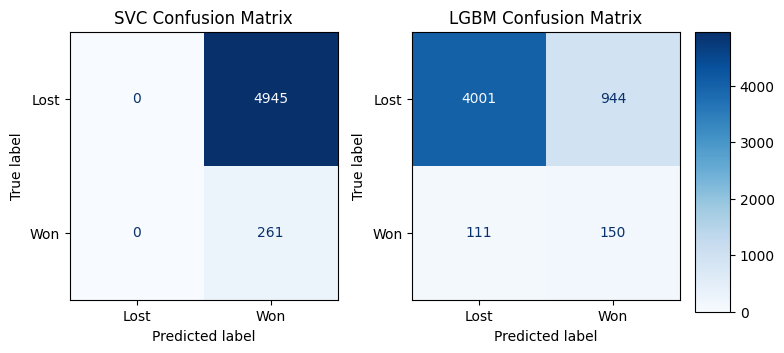

<Figure size 640x480 with 0 Axes>

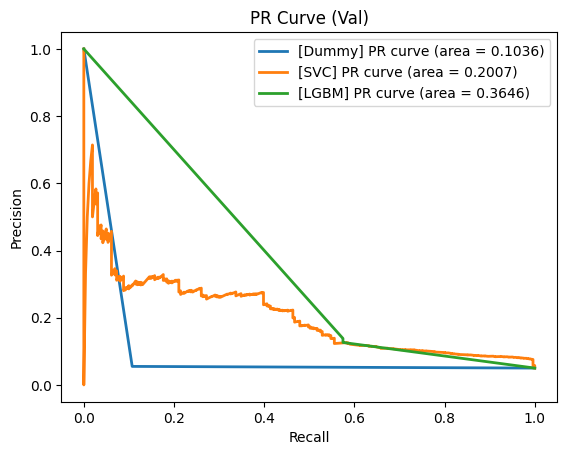

<Figure size 640x480 with 0 Axes>

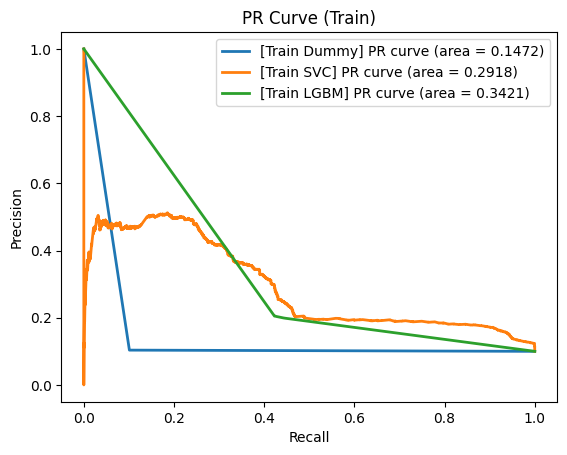

In [29]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_confusion_matrix(y_true, y_preds, classes, order, titles=None, normalize=None):    
    plt.clf()

    fig, axis = plt.subplots(1, len(y_preds), figsize=(7, 4))
    fig.subplots_adjust(hspace=0.05)
    im_kw = {
        'vmin': min([metrics.confusion_matrix(y_true, y_pred).flatten().min() for y_pred in y_preds]),
        'vmax': max([metrics.confusion_matrix(y_true, y_pred).flatten().max() for y_pred in y_preds])
    }
    norm = Normalize(**im_kw)
    for (y_pred, ax, title) in zip(y_preds, axis.flatten(), titles):
        disp = metrics.ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order, colorbar=False, im_kw=im_kw)
        ax.set(title=title, xticklabels=classes, yticklabels=classes)
    fig.tight_layout()
    cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
    fig.colorbar(ScalarMappable(norm=norm, cmap=plt.cm.Blues), cax=cbar_ax)
    
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = metrics.precision_recall_curve(y_true, pred)
            pr_auc = metrics.auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)

for ds, label in [(train, 'Train'), (test, 'Test'), (val, 'Val')]:
    for model_name in ['dummy', 'svc', 'lgbm']:
        get_report(get_metrics(ds.target, ds[f'{model_name}_pred'], ds[f'{model_name}_proba'], True), prefix=f"{label}\t{model_name}:")
        print()

plot_confusion_matrix(val.target.astype(int), [val.svc_pred, val.lgbm_pred], 
                      ['Lost', 'Won'], [0, 1], titles=["SVC Confusion Matrix", "LGBM Confusion Matrix"])
plot_pr_auc(val.target.astype(int), [val.dummy_proba, val.svc_proba, val.lgbm_proba], 
            labels=['Dummy', 'SVC', 'LGBM'], title='PR Curve (Val)')
plot_pr_auc(train.target.astype(int), [train.dummy_proba, train.svc_proba, train.lgbm_proba], 
            labels=['Train Dummy', 'Train SVC', 'Train LGBM'], title='PR Curve (Train)')


Based on the figures above, the following conclusions can be made about the baseline models. First, there is a clear overfit for both models, as they perform relatively well on the train sets but much less so on the test sets. While this is expected for SVCs that weren't tested against validation sets during training, this is unexpected for the LightGBM (with PR AUC being 0.1 for test but 0.71 for train), whose metric evaluation was conducted on the validation set during testing.

Nevertheless, SVC seems to perform marginally better - recall, which is an important metric in this scenario as we want to minimize false negatives, is significantly higher. SVC is generally better at figuring positive cases while not significantly losing in precision to LightGBM. It is likely that over larger sets of hyperparameters, LightGBM will be able to reduce its overfit and perform better on unseen data.

<Figure size 640x480 with 0 Axes>

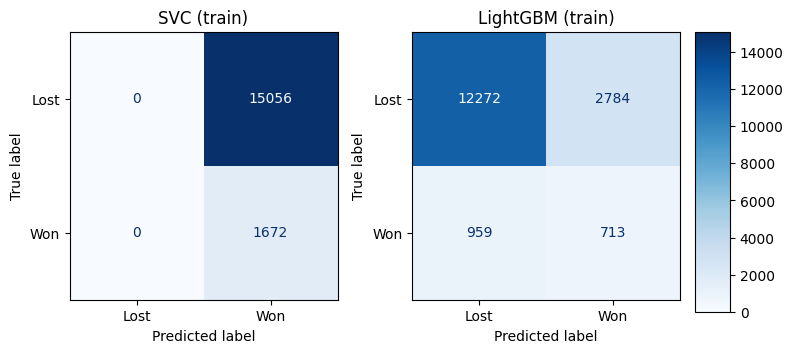

In [30]:
plot_confusion_matrix(train.target.astype(int), [train.svc_pred, train.lgbm_pred], 
                      ['Lost', 'Won'], [0, 1], titles=["SVC (train)", "LightGBM (train)"])

## Checkpoint

The code cell below saves all the models with a unique timestamp so that it could be retrieved in the future.

In [31]:
# save all models

models_dir = 'models'
Path(models_dir).mkdir(parents=True, exist_ok=True)

def save_all_models_and_pred(models, labels, train_df, test_df, val_df, svc_study_df, lgbm_study_df):
    model_path = f"{models_dir}/{int(time.time())}"
    Path(model_path).mkdir(parents=True)

    for m, l in zip(models, labels):
        with open(f'{model_path}/{l}_model.pkl', 'wb') as f:
            pickle.dump(m, f)
    with open(f'{model_path}/all_feature_names.pkl', 'wb') as f:
        pickle.dump(train_columns, f)
    train_df.to_csv(f'{model_path}/train.csv')
    test_df.to_csv(f'{model_path}/test.csv')
    val_df.to_csv(f'{model_path}/val.csv')
    svc_study_df.to_csv(f'{model_path}/svc_study.csv', index=False)
    lgbm_study_df.to_csv(f'{model_path}/lgbm_study.csv', index=False)


models = [dummy, svc, lgbm, scaler]
labels = ['dummy', 'svc', 'lgbm', 'scaler']
save_all_models_and_pred(models, labels, train, test, val, svc_trials_df, lgbm_trials_df)

In [32]:
print(', '.join([x for x in svc.feature_names_in_]))

current_duration, n__me, n__fc__rw7, n__tc__rw7, mean_duration_in__tc__rw7, mean_owner_included__tc__rw7, mean_n_recipients__fc__rw30, mean_n_recipients__tc__rw30, n__me__rw90, mean_duration_in__fc__rw90, mean_duration_in__me__rw90, n__me__x


In [33]:
print(', '.join([x for x in lgbm.feature_name_]))

n__me__rw7, mean_duration_in__me__rw7, mean_owner_included__fc__rw7, mean_owner_included__tc__rw30, mean_owner_included__fc__rw90, mean_duration_in__fc__x
